# 1.2.5.2 Challenge - Validating a Linear Regression Model

In [66]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton"
value="Show Code"></form>

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn import linear_model
import math
import scipy.stats
import statsmodels.formula.api as smf

%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format

import warnings
warnings.filterwarnings('ignore')

Bring in the FBI Crime Dataset for 2017 CSV and take a look at the first few rows. Our original model used the 2013 data.

In [41]:
data = pd.read_csv('FBI Crime Data 2017.csv')
data.head()

,State,Population,Violent crime,Murder and nonnegligent manslaughter,Rape1,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson2
0,Adams Village,1766,1,0,0,0,1,3,1,1,1,0
1,Addison Town and Village,2518,5,0,0,0,5,13,1,11,1,0
2,Afton Village,806,0,0,0,0,0,2,1,0,1,0
3,Akron Village,2848,4,0,0,0,4,7,0,6,1,0
4,Albany,98174,876,8,54,247,567,3394,432,2853,109,14


Do some data cleaning to make the dataset more usable and readible.

In [42]:
# Data cleaning

# Rename columns
data.columns = [['City', 'Population', 'Violent Crime', 'Murder', 'Rape1', 'Robbery', 'Agg Assault', 'Property Crime',
                'Burglary', 'Larceny', 'Vehicle Theft', 'Arson']]

cols = ['Population', 'Violent Crime', 'Murder', 'Rape1', 'Robbery', 'Agg Assault', 'Property Crime',
        'Burglary', 'Larceny', 'Vehicle Theft', 'Arson']

# Replace all NaN with 0
data[cols] = data[cols].replace(np.nan, 0)

# Convert strings to floats
def convert_number(number):
    try:
        converted = float(number.replace(',', ''))
    except:
        converted = number
    return converted

In [43]:
data['Population'] = data['Population'].apply(lambda x: convert_number(x))
data['Violent Crime'] = data['Violent Crime'].apply(lambda x: convert_number(x))
data['Murder'] = data['Murder'].apply(lambda x: convert_number(x))
data['Rape1'] = data['Rape1'].apply(lambda x: convert_number(x))
data['Robbery'] = data['Robbery'].apply(lambda x: convert_number(x))
data['Agg Assault'] = data['Agg Assault'].apply(lambda x: convert_number(x))
data['Property Crime'] = data['Property Crime'].apply(lambda x: convert_number(x))
data['Burglary'] = data['Burglary'].apply(lambda x: convert_number(x))
data['Larceny'] = data['Larceny'].apply(lambda x: convert_number(x))
data['Vehicle Theft'] = data['Vehicle Theft'].apply(lambda x: convert_number(x))
data['Arson'] = data['Arson'].apply(lambda x: convert_number(x))

Check out what the dataset looks like post-cleanup.

In [44]:
data.head()

,City,Population,Violent Crime,Murder,Rape1,Robbery,Agg Assault,Property Crime,Burglary,Larceny,Vehicle Theft,Arson
0,Adams Village,1766,1,0,0,0,1,3,1,1,1,0
1,Addison Town and Village,2518,5,0,0,0,5,13,1,11,1,0
2,Afton Village,806,0,0,0,0,0,2,1,0,1,0
3,Akron Village,2848,4,0,0,0,4,7,0,6,1,0
4,Albany,98174,876,8,54,247,567,3394,432,2853,109,14


Qualify the data as we did in the original linear regression model, specifically, removing cities with populations greater than 150,000 as it skews the data and should be modeled on its own.<br><br>
The following are the few cities that were removed based on population size.

In [55]:
# Filter out the cities that contain population sizes of 150,000 or greater.
datapop150k = data.loc[(data['Population'] < 150000).all(axis=1) | data.isnull().any(axis=1)]
 
# Which cities did we remove?
datapop150kremoved = data.loc[(data['Population'] > 150000).all(axis=1) | data.isnull().any(axis=1)]
datapop150kremoved

,City,Population,Violent Crime,Murder,Rape1,Robbery,Agg Assault,Property Crime,Burglary,Larceny,Vehicle Theft,Arson
38,Buffalo,256169,2611,40,142,857,1572,9827,2356,6638,833,192
226,New York,8616333,46433,292,2375,13995,29771,124815,11104,107976,5735,0
281,Rochester,208591,1872,27,141,707,997,7934,1337,5981,616,105
362,Yonkers,201554,810,8,36,271,495,2023,360,1481,182,15


Now let's see how each variable plots to see if there is any linearity to any of them.

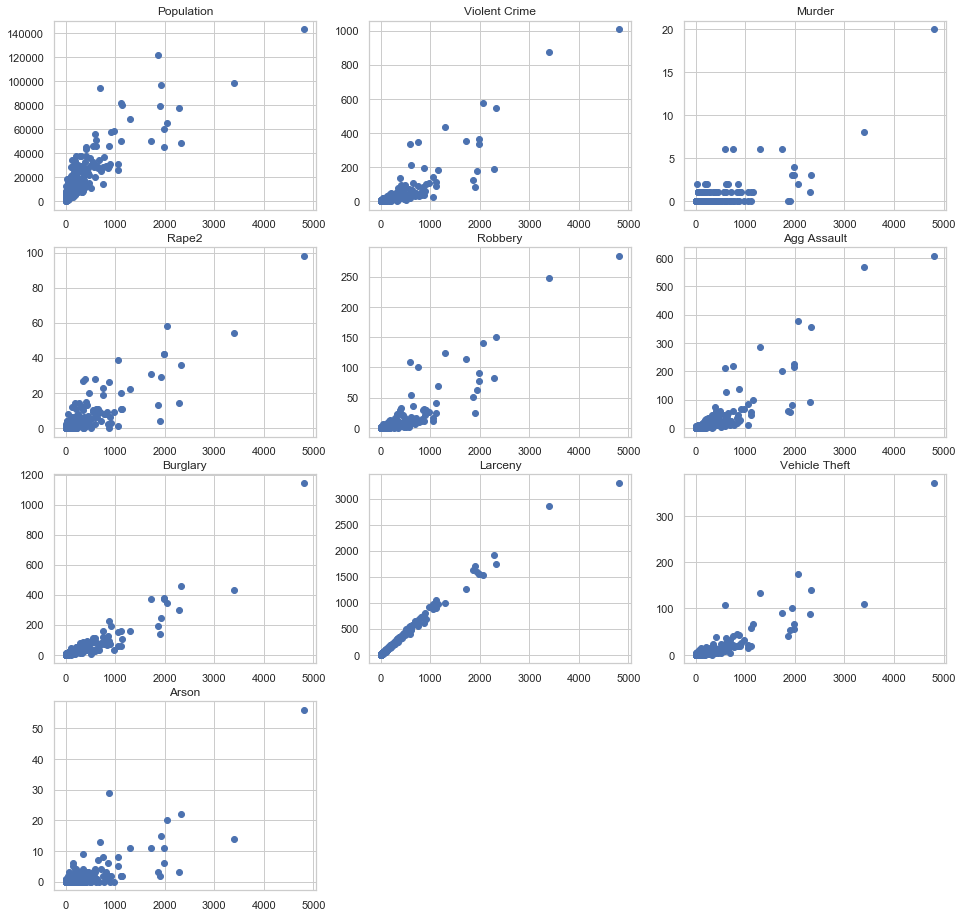

In [56]:
# Create a variable called for the outcome feature values
outcome = datapop150k['Property Crime']

plt.figure(figsize=(16,16))

#Population
plt.subplot(4, 3, 1)
plt.scatter(outcome, datapop150k['Population'])
plt.title('Population')

#Violent Crime
plt.subplot(4, 3, 2)
plt.scatter(outcome, datapop150k['Violent Crime'])
plt.title('Violent Crime')

#Murder
plt.subplot(4, 3, 3)
plt.scatter(outcome, datapop150k['Murder'])
plt.title('Murder')

#Rape1
plt.subplot(4, 3, 4)
plt.scatter(outcome, datapop150k['Rape1'])
plt.title('Rape2')

#Robbery
plt.subplot(4, 3, 5)
plt.scatter(outcome, datapop150k['Robbery'])
plt.title('Robbery')

#Aggravated Assault
plt.subplot(4, 3, 6)
plt.scatter(outcome, datapop150k['Agg Assault'])
plt.title('Agg Assault')

#Burglary
plt.subplot(4, 3, 7)
plt.scatter(outcome, datapop150k['Burglary'])
plt.title('Burglary')

#Larceny
plt.subplot(4, 3, 8)
plt.scatter(outcome, datapop150k['Larceny'])
plt.title('Larceny')

#Vehicle Theft
plt.subplot(4, 3, 9)
plt.scatter(outcome, datapop150k['Vehicle Theft'])
plt.title('Vehicle Theft')

#Arson
plt.subplot(4, 3, 10)
plt.scatter(outcome, datapop150k['Arson'])
plt.title('Arson')
 
plt.show()

Now let's instantiate the model and take a look at the model's statistics.

In [57]:
# Instantiate and fit the model using four different features - Population, Rape2, Robbery, and Agg Assault.
regr = linear_model.LinearRegression()
Y = datapop150k['Property Crime'].values.reshape(-1, 1)
X = datapop150k[['Population', 'Rape1', 'Robbery', 'Agg Assault']]
regr.fit(X, Y)

print('Coefficients: \n', regr.coef_)
print('\nIntercept:  \n', regr.intercept_)
print('\nR-Squared:')
print((regr.score(X, Y) * 100).round(3),'%')

Coefficients: 
 [[ 1.06274496e-02  1.59961227e+01  8.11467954e+00 -1.10922732e+00]]

Intercept:  
 [-12.6996344]

R-Squared:
91.392 %


The model seems to hold up! On our original test on the 2013 FBI data for NY State, we ended up with:<br><br>
__Intercept:__ -20.8805<br><br>
__R-Squared:__  91.455%
<br><br>
Looks like the model is doing pretty well!

# Here is where I tried adding in the methods from past challenges (Holdout groups, Crossvalidation, etc.) to no avail, and I have no idea what I should be doing differently. 

In [58]:
# Create the variables to run through the model
modeldata = datapop150k[['Population', 'Rape1', 'Robbery', 'Agg Assault']]
target = datapop150k['Property Crime']

In [65]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate the model as a variable
bnb = BernoulliNB()

# Fit the model to the data
bnb.fit(modeldata, target)

# Classify, storing the result in a new variable
y_pred = bnb.predict(modeldata)

In [64]:
# Test the model with different holdout groups
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(modeldata, target, test_size = 0.2, random_state = 20)
print('-----USING HOLDOUT-----')
print('With 20% Holdout:  ' + str(((bnb.fit(X_train, y_train).score(X_test, y_test)) * 100).round(2)) + '%')
print('Testing on Sample: ' + str(((bnb.fit(modeldata, target).score(modeldata, target)) * 100).round(2)) + '%')
print('')

from sklearn.model_selection import cross_val_score
print('-----LEAVE ONE OUT-----')
crossval = (cross_val_score(bnb, modeldata, target, cv=10))
print(crossval)
print('Mean: ' + str((crossval.mean() * 100).round(2)) + '%')
print('Stdv: ' + str((crossval.std() * 100).round(2)) + '%')

-----USING HOLDOUT-----
With 20% Holdout:  4.11%
Testing on Sample: 5.8%

-----LEAVE ONE OUT-----
[0.01860465 0.04477612 0.         0.05882353 0.08333333 0.125
 0.2        0.33333333 0.33333333 0.5       ]
Mean: 16.97%
Stdv: 15.89%
